In [1]:
# download from here https://github.com/bowang-lab/scGPT/tree/main?tab=readme-ov-file#pretrained-scGPT-checkpoints


import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins




/home/dario/PycharmProjects/ML-lab/venv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/dario/PycharmProjects/ML-lab/venv/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/dario/PycharmProjects/ML-lab/venv/lib/python3.12/site-packages/scgpt/model/model.py:21: UserW

In [2]:
# Specify model path; here we load the pre-trained scGPT blood model
model_dir = Path("model_params/")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from model_params/best_model.pt, the model args will override the config model_params/args.json.


In [20]:
import json

csv_file = 'data/TCGA_labels.csv'
df = pd.read_csv(csv_file)

with open(vocab_file) as f:
    genes_scgpt = json.load(f)

our_genes = set(s.split("..")[0] for s in df.columns)
scgpt_genes = set(genes_scgpt)

print(f"Number of genes and columns in our dataset: {len(our_genes)}")
print(f"Number of genes in scGPT: {len(scgpt_genes)}")
print(f"Number of genes in both: {len(our_genes.intersection(scgpt_genes))}")

Number of genes and columns in our dataset: 554
Number of genes in scGPT: 60697
Number of genes in both: 545


In [21]:
device = torch.device("cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file, map_location=device))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location=device)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)



Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [ ]:
csv_file = 'data/TCGA_labels.csv'
df = pd.read_csv(csv_file)
# remove is_true column
df = df.drop(columns=['is_true', "Variant_Classification", "mutation"])
# clip all values to positive
df = df.clip(lower=0)
# replace column names containing ".." with split[0] on ".."
df.columns = [s.split("..")[0] for s in df.columns]

# save to disk
df.to_csv('data/TCGA_labels_modified.csv', index=False)

In [40]:

adata = sc.read(
    "data/TCGA_labels_modified.csv", cache=False
)

ori_batch_col = "batch"
#adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
data_is_raw = True

# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata)

adata

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


AnnData object with n_obs × n_vars = 4211 × 551
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'bin_edges'
    layers: 'X_normed', 'X_log1p', 'X_binned'

In [47]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if
                   gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings) # actually 545 genes long


Retrieved gene embeddings for 545 genes.


100%|██████████| 545/545 [00:00<00:00, 1189331.78it/s]


['PTPRU',
 'PTP4A1',
 'PRPF40A',
 'PRKCH',
 'PRKCE',
 'PRKAB1',
 'PRDM1',
 'POU2F2',
 'POLD3',
 'POLD1',
 'PLCB1',
 'PLB1',
 'PLAC8',
 'PDGFRB',
 'PDE4C',
 'PTPN13',
 'PCBP3',
 'PAX5',
 'PALLD',
 'OGG1',
 'NUAK2',
 'NRXN1',
 'NRG1',
 'NPFFR2',
 'PGF',
 'BCL2L1',
 'NKX3-1',
 'NFYC',
 'NFKB1',
 'NFIC',
 'PHACTR4',
 'ASTN2',
 'NEDD4L',
 'KITLG',
 'DDB2',
 'MYO5A',
 'MYH13',
 'PLAGL1',
 'MPRIP',
 'MMP2',
 'MICAL3',
 'AHDC1',
 'MET',
 'MED4',
 'MDM4',
 'MDM2',
 'EXT1',
 'MACF1',
 'NRP2',
 'FUS',
 'CDC42EP3',
 'LRP1',
 'LMNA',
 'MED15',
 'PDE4D',
 'TERT',
 'APAF1',
 'RNF216',
 'GML',
 'DCDC1',
 'DLEU1',
 'NXN',
 'SYNE1',
 'ARID1B',
 'PLXNA2',
 'NAV3',
 'PTEN',
 'PLXNB1',
 'LRP5',
 'DCP1B',
 'LIMCH1',
 'MAP4K4',
 'ANKRD37',
 'PTTG1',
 'ARID1A',
 'BAIAP2',
 'KRT80',
 'KIAA1217',
 'KEL',
 'MYEOV',
 'DLG1',
 'KCNN3',
 'KCNMA1',
 'KCNJ12',
 'NCOR2',
 'KALRN',
 'ITGAM',
 'INPP5B',
 'INPP5A',
 'BRCA1',
 'GLIS3',
 'PRC1',
 'EFNA5',
 'PCNA',
 'IFI16',
 'ID1',
 'HTT',
 'MAP4',
 'HS1BP3',
 'IGF2BP2',
 

In [66]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    
    if len(genes) > 3:
        mgs[mg] = genes
mgs

{'22': ['PDGFRB', 'CALD1', 'TCEAL1', 'ACTA2'],
 '10': ['PCBP3', 'CASZ1', 'MYO3B', 'SLC6A6'],
 '9': ['NRXN1', 'CSMD1', 'CDH8', 'CSMD3'],
 '8': ['PGF', 'CDC42EP3', 'MMP1', 'SERPINE1'],
 '12': ['BCL2L1', 'MDM2', 'ERGIC1', 'PACSIN2'],
 '21': ['MYH13', 'CLEC3A', 'BGLAP', 'PRG3'],
 '17': ['MMP2', 'COL1A1', 'FBLN2', 'FBLN1'],
 '18': ['AHDC1', 'SERTAD2', 'DAB2IP', 'FOXK1'],
 '19': ['MET', 'RB1', 'FCHO2', 'CDK5RAP2'],
 '0': ['DCDC1', 'FRMPD2', 'FAM183A', 'FHAD1', 'EFHC1', 'RPGR'],
 '6': ['MAP4K4', 'TCF4', 'FAM13C', 'GNAI1'],
 '3': ['PTTG1', 'PLK1', 'CCNB1', 'CCNA1', 'CCNB2'],
 '13': ['NCOR2', 'RASA3', 'ZMIZ1', 'SULF2'],
 '2': ['PRC1', 'CCNA2', 'BIRC5', 'CDK1', 'MKI67'],
 '7': ['TMEM217', 'PER2', 'DCUN1D3', 'TNFRSF10B'],
 '4': ['FDXR', 'TRIAP1', 'ALKBH2', 'MCAT'],
 '16': ['DOCK10', 'ZBTB20', 'ERBB4', 'TCF12'],
 '1': ['HSP90AB1', 'ACTB', 'GSTP1', 'TKT', 'RPS19'],
 '15': ['S100A2', 'SERPINB5', 'AQP3', 'SFN'],
 '20': ['CHN2', 'IQCJ', 'SCHIP1', 'STAT1'],
 '14': ['AMOTL1', 'GNG4', 'TOX2', 'VAV2'],
 '

In [67]:
sns.set(font_scale=0.35)
#embed.score_metagenes(adata, metagenes)
#embed.plot_metagenes_scores(adata, mgs, "celltype")



In [68]:
# Retrieve gene program 3 which contains the CD3 gene set
CD_genes = mgs['3']
print(CD_genes)
print(type(CD_genes))
CD_genes = [gene for mg, genes in mgs.items() for gene in genes]
# Compute cosine similarities among genes in this gene program
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    # this append does not work
    #df_CD = df_CD.append(df)
    
    df_CD = pd.concat([df_CD, df], ignore_index=True)
    
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to 

['PTTG1', 'PLK1', 'CCNB1', 'CCNA1', 'CCNB2']
<class 'list'>


100%|██████████| 97/97 [00:03<00:00, 30.07it/s]


In [69]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

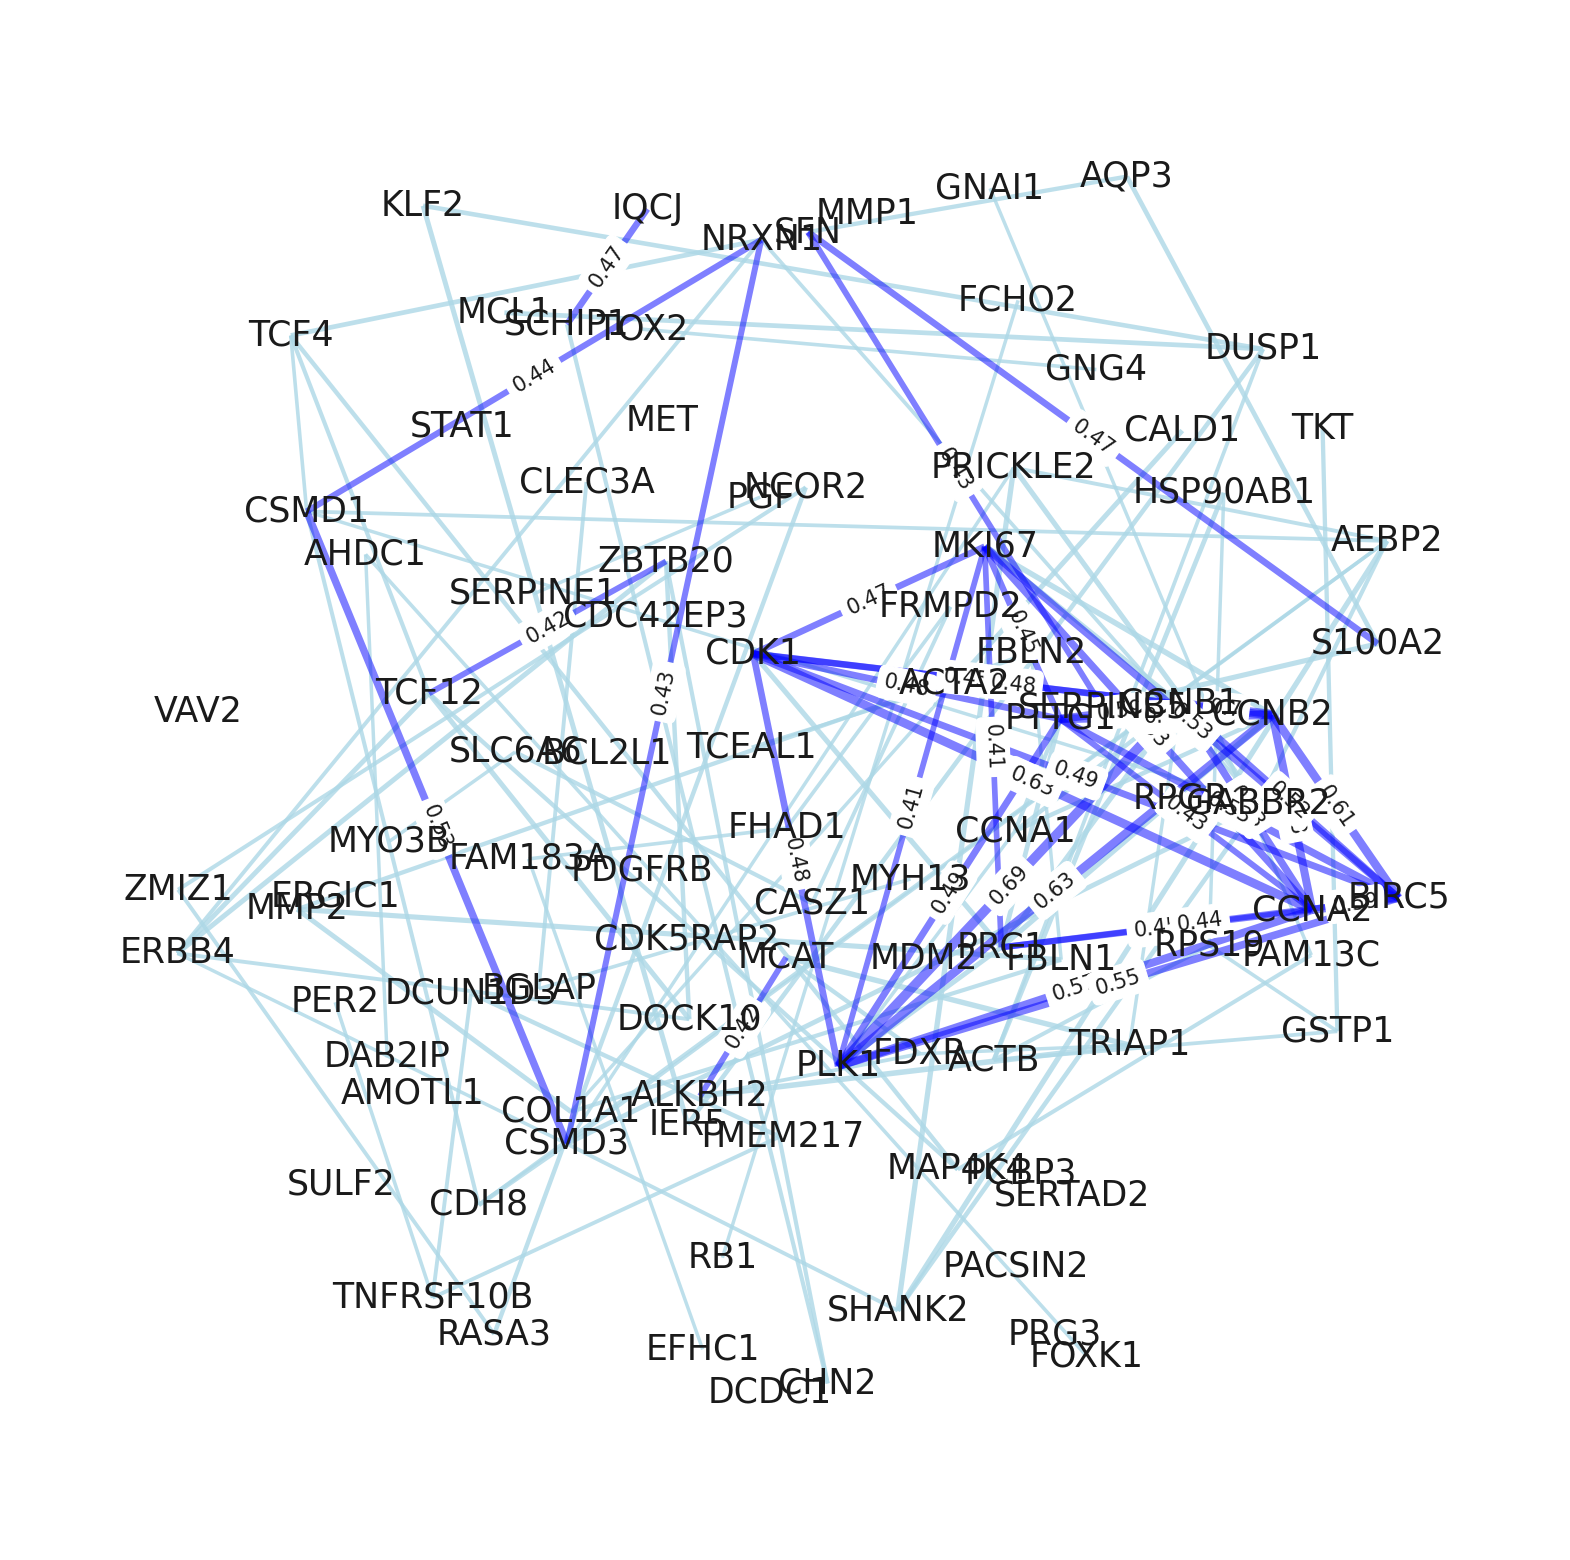

In [74]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
lower_thresh = 0.25
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v < lower_thresh:
        continue
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos,
                       edgelist = width_large.keys(),
                       width = list(width_large.values()),
                       alpha = 0.5,
                       edge_color = "blue",
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()

